In [1]:
import os
import sys
if True:
    sys.path.insert(0, '../')
import torch
import numpy as np
from glob import glob
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
import pandas as pd
from utils.store_data import ReadData
import numpy as np
import torch
from utils.arguments import Arguments
from tqdm import tqdm
from linear_probe import get_linear_acc
import random
from sklearn.metrics import roc_auc_score,accuracy_score,roc_curve

In [2]:
data_reader=ReadData('/root/autodl-tmp/hallscope/pope/adversarial/train')
data=data_reader.read_all()
random.shuffle(data)

In [3]:
df=pd.DataFrame(data)

In [4]:
df.head()

,img_path,question,label,question_id,category,most_likely,responses
0,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a car in the image?\nAnswer the ques...,[tensor(0)],[tensor(992)],[adversarial],{'embedding': [[[ 0.00099182 0.0020752 -0.00...,None
1,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a pizza in the image?\nAnswer the qu...,[tensor(1)],[tensor(6107)],[adversarial],{'embedding': [[[ 0.00099182 0.0020752 -0.00...,None
2,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a bus in the image?\nAnswer the ques...,[tensor(1)],[tensor(10619)],[adversarial],{'embedding': [[[ 0.00099182 0.0020752 -0.00...,None
3,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a dining table in the image?\nAnswer...,[tensor(1)],[tensor(10637)],[adversarial],{'embedding': [[[ 0.00099182 0.0020752 -0.00...,None
4,[/root/autodl-fs/coco_images/train/COCO_train2...,[Is there a refrigerator in the image?\nAnswer...,[tensor(1)],[tensor(8323)],[adversarial],{'embedding': [[[ 0.00099182 0.0020752 -0.00...,None


In [5]:
embeddings=df['most_likely'].apply(lambda x: x['embedding']).to_list()

In [6]:
embeddings=np.concatenate(embeddings,axis=0)

In [7]:
embeddings.shape

(10000, 29, 3584)

In [8]:
gt_label=df['label'].to_list()
gt_label=np.concatenate(gt_label,axis=0)

In [9]:
gt_label.shape

(10000,)

In [10]:
responses=df['most_likely'].apply(lambda x: x['response']).to_list()
resps=[]
for x in responses:
    resps+=x

In [11]:
is_correct=[]
for i,x in enumerate(resps):
    if x.lower()=='no' and gt_label[i]==0:
        is_correct.append(1)
    elif x.lower()=='yes' and gt_label[i]==1:
        is_correct.append(1)
    else:
        is_correct.append(0)
is_correct=np.array(is_correct)

In [12]:
is_correct.shape

(10000,)

In [13]:
print(f'There are {len(is_correct)} responses. {sum(is_correct==1)} answer correctly and {sum(is_correct==0)} answer wrongly')

There are 10000 responses. 8692 answer correctly and 1308 answer wrongly


In [14]:
length=len(is_correct)
train_rate=0.8

all_indices = np.random.permutation(length)
train_val_idxs = all_indices[:int(
    train_rate * length)]  # trainset and validation index

test_idxs=all_indices[int(
    train_rate * length):]  #test index

validset_len = 2000
# exclude validation samples.
train_idxs = train_val_idxs[:len(
    train_val_idxs) - validset_len]  # trainset index
val_idxs = train_val_idxs[len(
    train_val_idxs) - validset_len:]  # validation index
hall_label_test = []
hall_label_wild = []
hall_label_val = []

'''get testset, wildset and valset. The valset is used for determining the hype-parameters'''
hall_label_test = is_correct[test_idxs]
hall_label_wild = is_correct[train_idxs]
hall_label_val = is_correct[val_idxs]

print(f'trainset length:{len(hall_label_wild)}')
print(f'validset length:{len(hall_label_val)}')
print(f'testset length:{len(hall_label_test)}')
print(f'trainset postive: {sum(hall_label_wild==1)} negative: {sum(hall_label_wild==0)}')
print(f'valset postive: {sum(hall_label_val==1)} negative: {sum(hall_label_val==0)}')
print(f'testset postive: {sum(hall_label_test==1)} negative: {sum(hall_label_test==0)}')

trainset length:6000
validset length:2000
testset length:2000
trainset postive: 5223 negative: 777
valset postive: 1736 negative: 264
testset postive: 1733 negative: 267


In [15]:
all_embeddings = embeddings
all_embeddings.shape

(10000, 29, 3584)

In [16]:
embedding_train = all_embeddings[train_idxs]
embedding_val = all_embeddings[val_idxs]
embedding_test = all_embeddings[test_idxs]

In [17]:
%load_ext autoreload
%autoreload 2
from ml_utils.grid_search import GridSearch
from ml_utils.PCA_discriminator import PCALinear,PCAKernel,KernelPCA
from sklearn.metrics import roc_auc_score,accuracy_score,roc_curve,f1_score,balanced_accuracy_score
from ml_utils.metrics import auc_pr

Grid Search for Best 'n_components' & 'layer'

In [18]:
M=3584
def evaluator(n_components,i_layer,X,y):
    discriminator=KernelPCA(X[:,i_layer,:],n_components,M,method='CoP',gamma=1)
    scores=discriminator.get_score(X[:,i_layer,:])
    
    return roc_auc_score(y,scores)
    #split=discriminator.get_best_split(scores,y)
    #y_pred=scores>split
    #return accuracy_score(y,y_pred)
    #return balanced_accuracy_score(y,y_pred)
    
    #split=discriminator.get_best_split(y)
    #y_preds=(scores>split)
    #return accuracy_score(y,y_preds)

In [19]:
# graid search for best hyper-parameters on validation set
grid={
    'n_components':range(1,4),
    'layer':range(10,embedding_val.shape[1])
}
grid_search=GridSearch(evaluator,grid,embedding_val,hall_label_val)
best_paras=grid_search.search()

Grid Searching for best n_components,layer


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

found best n_components:1,layer:10 Score: 0.5033536691802821
found best n_components:1,layer:15 Score: 0.5047239386957129
found best n_components:1,layer:16 Score: 0.7029678990364474
found best n_components:1,layer:17 Score: 0.7953410836475352
found best n_components:1,layer:18 Score: 0.8026571882418656


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

found best n_components:3,layer:27 Score: 0.8046951368523949


In [ ]:
best_paras

{'n_components': 3, 'layer': 27, 'best_score': np.float64(0.8046951368523949)}

In [21]:
best_layer=best_paras['layer']
#best_layer=24

View Results on Training set and Test set

In [22]:
discriminator=KernelPCA(embedding_val[:,best_layer,:],2,M,method='CoP',gamma=1)
scores=discriminator.get_score(embedding_val[:,best_layer,:])
best_split=discriminator.get_best_split(scores,hall_label_val)

In [23]:
X_pca=discriminator.transform(embedding_val[:,best_layer,:])

In [24]:
X_pca.shape

(2000, 2)

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Load sample data (handwritten digits)
data = embedding_val[:,best_layer,:]
labels = hall_label_val
custom_cmap = ListedColormap([ 'red','green'])
# Fit and transform the data
tsne_result = embedding_val[:,best_layer,:]

# Plotting the t-SNE result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap=custom_cmap, s=5)
plt.colorbar(scatter)
plt.title('KPCA Visualization of Digits Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

NameError: name 'ListedColormap' is not defined

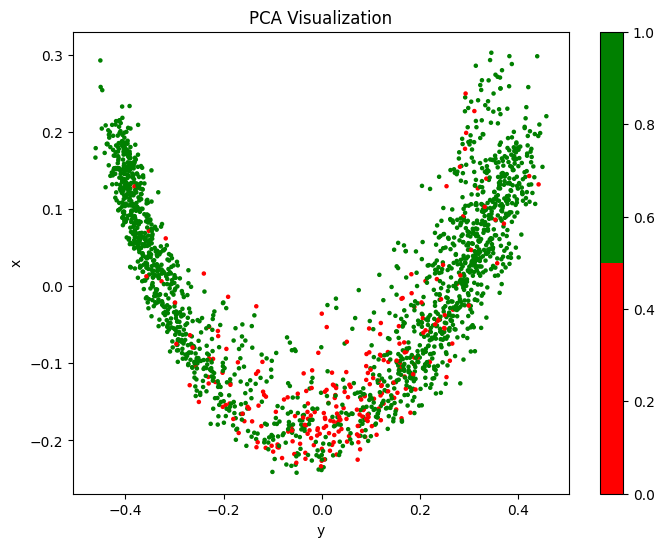

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load sample data
data = X_pca
labels = hall_label_val

# Create a custom colormap
custom_cmap = ListedColormap([ 'red','green'])

# Fit and transform the data
tsne_result = X_pca

# Plotting the t-SNE result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap=custom_cmap, s=5)
plt.colorbar(scatter)
plt.title('PCA Visualization')
plt.xlabel('y')
plt.ylabel('x')
plt.show()

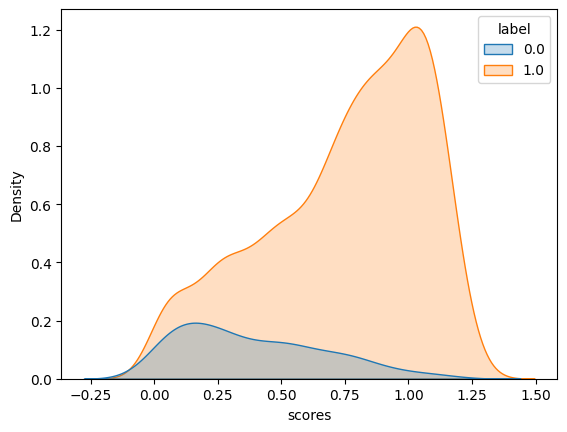

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data=np.stack((scores,hall_label_val)).T

df = pd.DataFrame(data, columns=['scores', 'label'])

# Create a density plot
sns.kdeplot(data=df, x="scores", hue="label", fill=True)

# Show the plot
plt.show()

In [ ]:
data.shape

(2000, 2)